<a href="https://colab.research.google.com/github/PavelNovikov888/practical_work/blob/master/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import sqrt, exp

from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn import cluster
from sklearn import feature_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Прочитаем наш файл с исходными данными:

In [ ]:
taxi_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_5/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [ ]:
taxi_data['pickup_datetime']=pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [ ]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [ ]:
taxi_data.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06


In [ ]:
#cколько уникальных таксопарков присутствует в данных
len(taxi_data['vendor_id'].unique())

2

In [ ]:
#каково максимальное количество пассажиров
taxi_data['passenger_count'].max()

9

In [ ]:
taxi_data['trip_duration'].describe().round()

count    1458644.0
mean         959.0
std         5237.0
min            1.0
25%          397.0
50%          662.0
75%         1075.0
max      3526282.0
Name: trip_duration, dtype: float64

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [ ]:
def add_datetime_features(data):
  data['pickup_date'] = data['pickup_datetime'].dt.date
  data['pickup_hour'] = data['pickup_datetime'].dt.hour
  data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek
  return data


In [ ]:
df = taxi_data.copy()
df = add_datetime_features(df)
sat_count = df['pickup_day_of_week'].value_counts()[5]
print(f'Количество поездок в субботу: {sat_count}')
mean_trip = df['pickup_date'].value_counts().mean().round(0).astype(np.int16)
print(f'Поездок в среднем в день: {mean_trip}')


Количество поездок в субботу: 220868
Поездок в среднем в день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [ ]:
holiday_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/holiday_data.csv', sep=';')
def add_holiday_features(trip_data,holidays_data):
  holidays_data['date'] = pd.to_datetime(holidays_data['date'], format='%Y-%m-%d %H:%M:%S')
  holidays_data['date'] = holidays_data['date'].dt.date
  trip_data['pickup_holiday'] = trip_data['pickup_date'].apply(lambda x: 1 if x in holidays_data['date'].values else 0)
  return trip_data

In [ ]:
df = add_holiday_features(df,holiday_data)
df['pickup_holiday'].value_counts()

0    1407522
1      51122
Name: pickup_holiday, dtype: int64

In [ ]:
mask = df['pickup_holiday'] == 1
median_dataframe = df[mask]['trip_duration'].median()
print(median_dataframe)

585.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

In [ ]:
holiday_data.head()

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
osrm_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/osrm_data_train.zip')
# ваш код здесь

In [ ]:
def add_osrm_features(trip_data,data_osrm):
  data_osrm = data_osrm[['id','total_distance','total_travel_time','number_of_steps']]
  merged_data = trip_data.merge(
    data_osrm,
    on='id',
    how='left'
  )
  return merged_data

In [ ]:
df_trip = add_osrm_features(df,osrm_data)
df_trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int64         
 13  pickup_day_o

In [ ]:
taxi_data['trip_duration'].median().round() - df_trip['total_travel_time'].median().round()

372.0

In [ ]:
df_trip.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [ ]:
def add_geographical_features(data_trip):
  data_trip['haversine_distance', 'direction'] = 0
  for i in range(0,len(data_trip)):
    lat1 = data_trip.loc[i,'pickup_latitude']
    lng1 = data_trip.loc[i,'pickup_longitude']
    lat2 = data_trip.loc[i,'dropoff_latitude']
    lng2 = data_trip.loc[i,'dropoff_longitude']
    data_trip.loc[i,'haversine_distance'] = get_haversine_distance(lat1, lng1, lat2 , lng2)
    data_trip.loc[i,'direction'] = get_angle_direction(lat1, lng1, lat2 , lng2)
  return data_trip  

In [ ]:

#df_trip = add_geographical_features(df_trip)
#print('Медианное расстояние Хаверсина: {:.2f}'.format(df_trip['haversine_distance'].median()))

In [ ]:
er = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/ff.zip')

In [ ]:
er.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 22 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Unnamed: 0                           1458644 non-null  int64  
 1   id                                   1458644 non-null  object 
 2   vendor_id                            1458644 non-null  int64  
 3   pickup_datetime                      1458644 non-null  object 
 4   dropoff_datetime                     1458644 non-null  object 
 5   passenger_count                      1458644 non-null  int64  
 6   pickup_longitude                     1458644 non-null  float64
 7   pickup_latitude                      1458644 non-null  float64
 8   dropoff_longitude                    1458644 non-null  float64
 9   dropoff_latitude                     1458644 non-null  float64
 10  store_and_fwd_flag                   1458644 non-null  object 
 11

In [ ]:
er.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,"('haversine_distance', 'direction')",haversine_distance,direction
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,...,2016-03-14,17,0,0,2009.1,164.9,5.0,0,1.498521,99.970196
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,...,2016-06-12,0,6,0,2513.2,332.0,6.0,0,1.805507,-117.153768
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,...,2016-01-19,11,1,0,11060.8,767.6,16.0,0,6.385098,-159.680165
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,...,2016-04-06,19,2,0,1779.4,235.8,4.0,0,1.485498,-172.737700
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,...,2016-03-26,13,5,0,1614.9,140.1,5.0,0,1.188588,179.473585


In [ ]:
er.drop(er.columns[[0,19]], axis = 1, inplace = True)

In [ ]:
taxi_data = er.copy()

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

In [ ]:
coords

array([[ 40.76793671, -73.98215485,  40.76560211, -73.96463013],
       [ 40.73856354, -73.98041534,  40.73115158, -73.9994812 ],
       [ 40.7639389 , -73.97902679,  40.71008682, -74.00533295],
       ...,
       [ 40.76879883, -73.95912933,  40.70737076, -74.00443268],
       [ 40.74906158, -73.98207855,  40.75710678, -73.97463226],
       [ 40.78174973, -73.97953796,  40.79058456, -73.97280884]])

In [ ]:
def add_cluster_features(data_trip, kmeans):
  coords = np.hstack((data_trip[['pickup_latitude', 'pickup_longitude']],
                    data_trip[['dropoff_latitude', 'dropoff_longitude']]))
  data_pred = kmeans.predict(coords)
  data_trip['geo_cluster'] = data_pred
  return data_trip 

In [ ]:
df_trip = add_cluster_features(taxi_data, kmeans)
df_trip['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/weather_data.zip')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
def add_weather_features(data_trip, weather):
  weather = weather[['time','temperature','visibility','wind speed','precip','events','date','hour']]
  data_merge = data_trip.merge(
    weather,
    right_on = ["date","hour"],
    left_on = ["pickup_date","pickup_hour"],
    how = 'left')
  data_merge.drop(columns = ['time','date','hour'], inplace = True)
  return data_merge

In [ ]:
df_trip = add_weather_features(df_trip, weather_data)

In [ ]:
snow = df_trip.groupby('events')['vendor_id'].count()['Snow']
print(f'В снежную погоду было совершено {snow} поездок.')

В снежную погоду было совершено 13126 поездок.


In [ ]:
# посчитаем пропуски во всех столбцах
for col in df_trip.columns:
    pct_missing = df_trip[col].isna().mean()
    print(f'{col} - {pct_missing :.2%}')

id - 0.00%
vendor_id - 0.00%
pickup_datetime - 0.00%
dropoff_datetime - 0.00%
passenger_count - 0.00%
pickup_longitude - 0.00%
pickup_latitude - 0.00%
dropoff_longitude - 0.00%
dropoff_latitude - 0.00%
store_and_fwd_flag - 0.00%
trip_duration - 0.00%
pickup_date - 0.00%
pickup_hour - 0.00%
pickup_day_of_week - 0.00%
pickup_holiday - 0.00%
total_distance - 0.00%
total_travel_time - 0.00%
number_of_steps - 0.00%
haversine_distance - 0.00%
direction - 0.00%
geo_cluster - 0.00%
temperature - 0.82%
visibility - 0.82%
wind speed - 0.82%
precip - 0.82%
events - 0.82%


## Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [ ]:
def fill_null_weather_data(data_trip):
  data_trip[['temperature', 'visibility', 'wind speed', 'precip']] = data_trip[['temperature', 'visibility', 'wind speed', 'precip']].fillna(
  data_trip.groupby('pickup_date')[['temperature', 'visibility', 'wind speed', 'precip']].transform('median'))
  #создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
  values = {
    'total_distance': data_trip['total_distance'].median(),
    'total_travel_time': data_trip['total_travel_time'].median(),
    'number_of_steps': data_trip['number_of_steps'].median(),
    'events': 'None'
  }
  #заполняем оставшиеся записи константами в соответствии со словарем values
  data_trip = data_trip.fillna(values)
  #выводим результирующую долю пропусков
  display(data_trip.isnull().mean())
  return data_trip


In [ ]:
df_trip = fill_null_weather_data(df_trip)

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
pickup_date           0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_holiday        0.0
total_distance        0.0
total_travel_time     0.0
number_of_steps       0.0
haversine_distance    0.0
direction             0.0
geo_cluster           0.0
temperature           0.0
visibility            0.0
wind speed            0.0
precip                0.0
events                0.0
dtype: float64

In [ ]:
#медиана в столбце temperature после заполнения пропусков
df_trip['temperature'].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


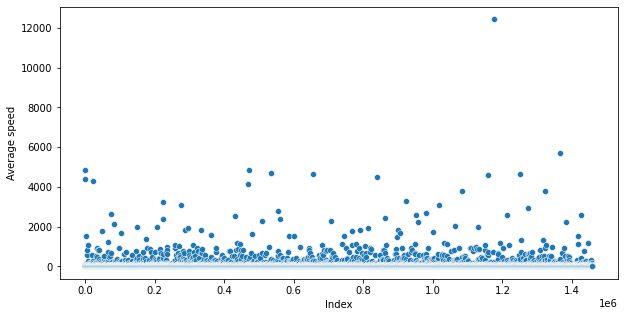

In [ ]:
avg_speed = df_trip['total_distance'] / df_trip['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [ ]:
mask_duration = df_trip['trip_duration'] > 24*60*60
dura_otl = df_trip[mask_duration]['id'].count()
print(f'Количество выбросов по признаку длительности поездки: {dura_otl}')
df_trip.drop(df_trip[mask_duration].index, axis = 0, inplace = True)

Количество выбросов по признаку длительности поездки: 4


In [ ]:
df_trip[['trip_duration','haversine_distance']].describe().T

,count,mean,std,min,25%,50%,75%,max
trip_duration,1458640.0,952.815252,3171.322283,1.0,397.000000,662.000000,1075.000000,86392.000000
haversine_distance,1458640.0,3.440841,4.296499,0.0,1.231834,2.093711,3.875323,1240.908677


In [ ]:
df_trip['speed'] = df_trip['total_distance'] / df_trip['trip_duration'] * 3.6
mask_speed = df_trip['speed'] > 300
speed_otl = df_trip[mask_speed]['id'].count()
print(f'Количество выбросов по признаку длительности поездки: {speed_otl}')
df_trip.drop(df_trip[mask_speed].index, axis = 0, inplace = True)
df_trip.drop(columns = ['speed'], axis = 1, inplace = True)

Количество выбросов по признаку длительности поездки: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
df_trip['trip_duration_log'] = np.log(df_trip['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

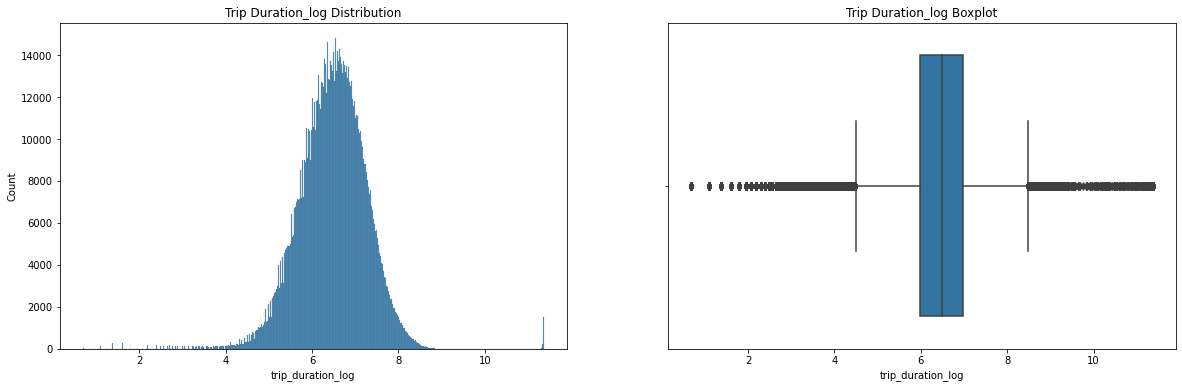

In [ ]:
# ваш код здесь
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
histplot = sns.histplot(data=df_trip, x='trip_duration_log', ax=axes[0]);
histplot.set_title('Trip Duration_log Distribution');
boxplot = sns.boxplot(data=df_trip, x='trip_duration_log', ax=axes[1]);
boxplot.set_title('Trip Duration_log Boxplot');

In [ ]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
#установим уровень значимости
alpha = 0.05

In [ ]:
from scipy.stats import normaltest

In [ ]:
stat, p = normaltest(df_trip['trip_duration_log'])
# normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('Statistics=%.10f, p=%.3f' % (stat, p))

# Интерпретация

if p > alpha/2:
    print(H0)
else:
    print(Ha)

Statistics=138350.1660540500, p=0.000
Данные не распределены нормально (мы отвергаем H0)


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

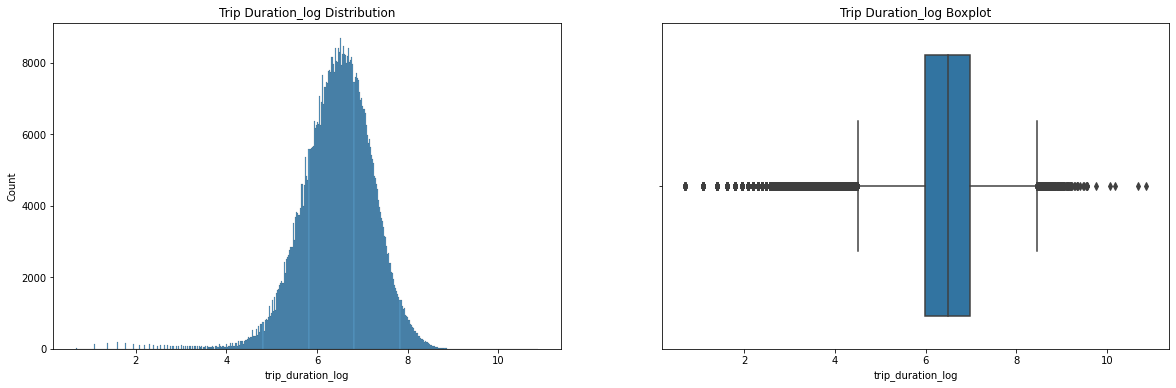

In [ ]:
# ваш код здесь
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
mask1 = df_trip['vendor_id'] == 1
histplot = sns.histplot(data=df_trip[mask1], x='trip_duration_log', ax=axes[0]);
histplot.set_title('Trip Duration_log Distribution');
boxplot = sns.boxplot(data=df_trip[mask1], x='trip_duration_log', ax=axes[1]);
boxplot.set_title('Trip Duration_log Boxplot');

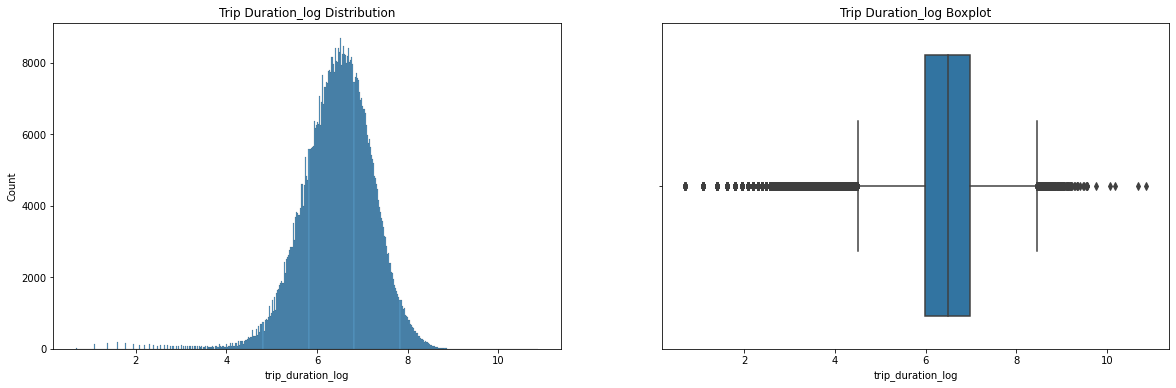

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
mask2 = df_trip['vendor_id'] == 2
histplot = sns.histplot(data=df_trip[mask1], x='trip_duration_log', ax=axes[0]);
histplot.set_title('Trip Duration_log Distribution');
boxplot = sns.boxplot(data=df_trip[mask1], x='trip_duration_log', ax=axes[1]);
boxplot.set_title('Trip Duration_log Boxplot');

In [ ]:
mask1 = df_trip['vendor_id'] == 1
mask2 = df_trip['vendor_id'] == 2
data1 = df_trip[mask1]['trip_duration_log']
data2 = df_trip[mask2]['trip_duration_log']

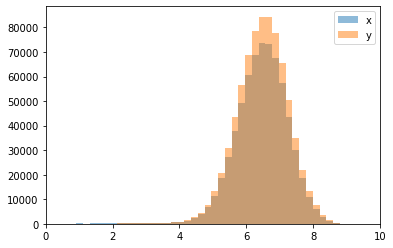

In [ ]:
bins = np.linspace(-10, 10, 100)
plt.hist(data1, bins, alpha=0.5, label='x')
plt.hist(data2, bins, alpha=0.5, label='y')
plt.xlim(0,10)
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


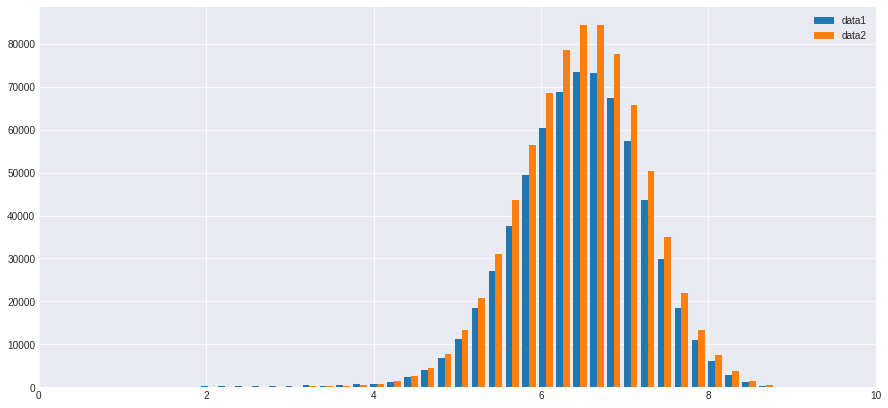

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 7))
plt.hist([data1, data2], bins, label=['data1', 'data2'])
plt.xlim(0,10)
plt.legend(loc='upper right')
plt.show()

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

In [ ]:
df_trip['store_and_fwd_flag'].value_counts()

N    1450192
Y       8041
Name: store_and_fwd_flag, dtype: int64

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


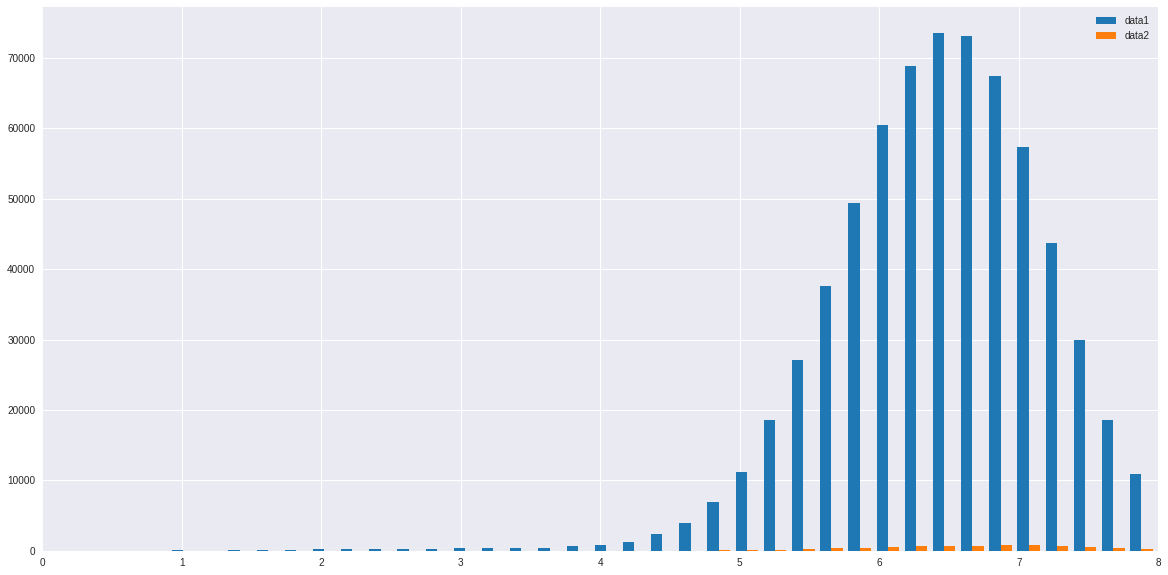

In [ ]:
nask1 = df_trip['store_and_fwd_flag'] == 'N'
mask2 = df_trip['store_and_fwd_flag'] == 'Y'
data1 = df_trip[mask1]['trip_duration_log']
data2 = df_trip[mask2]['trip_duration_log']

plt.style.use('seaborn-notebook');

plt.figure(figsize=(20, 10));

plt.hist([data1, data2], bins, label=['data1', 'data2']);
plt.xlim(0, 8)
plt.legend(loc='upper right');
plt.show();

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

In [ ]:
# ваш код здесь

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [ ]:
dataset_trip_count = df_trip.groupby('pickup_hour')['id'].count()
dataset_trip_duration = df_trip.groupby('pickup_hour')['trip_duration'].median()

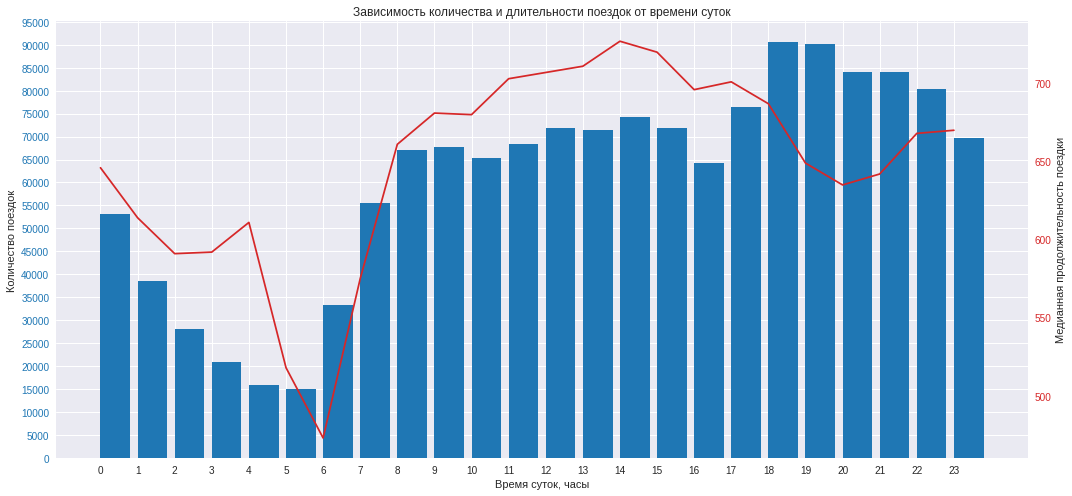

In [ ]:
# Create some mock data
data1 = dataset_trip_count
data2 = dataset_trip_duration
x = np.arange(len(dataset_trip_count))  # the label locations
width = 0.8  # the width of the bars

fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.bar(x + width/2, dataset_trip_count, width, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Количество поездок')
ax1.set_xlabel('Время суток, часы')
ax1.set_title('Зависимость количества и длительности поездок от времени суток')
ax1.set_xticks(range(0, 24))
ax1.set_yticks(range(0, 100000, 5000));

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.grid() 
ax2.set_xlabel('Время суток, часы')
ax2.set_ylabel('Медианная продолжительность поездки')
ax2.plot(dataset_trip_duration,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


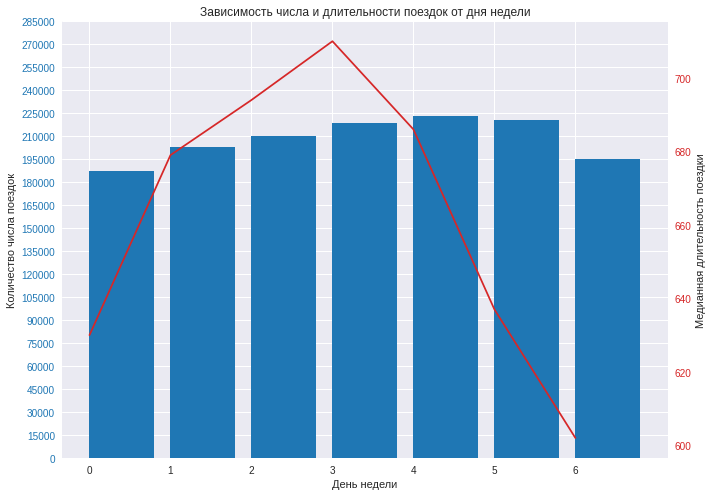

In [ ]:
# ваш код здесь
dataset_trip_count = df_trip.groupby('pickup_day_of_week')['id'].count()
dataset_trip_duration = df_trip.groupby('pickup_day_of_week')['trip_duration'].median()

# Create some mock data
data1 = dataset_trip_count
data2 = dataset_trip_duration
x = np.arange(len(dataset_trip_count))  # the label locations
width = 0.8  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 7))

color = 'tab:blue'
ax1.bar(x + width/2, dataset_trip_count, width, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Количество числа поездок')
ax1.set_xlabel('День недели')
ax1.set_title('Зависимость числа и длительности поездок от дня недели')
ax1.set_xticks(range(0, 7))
ax1.set_yticks(range(0, 300000, 15000));

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.grid() 
ax2.set_xlabel('День недели')
ax2.set_ylabel('Медианная длительность поездки')
ax2.plot(dataset_trip_duration,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

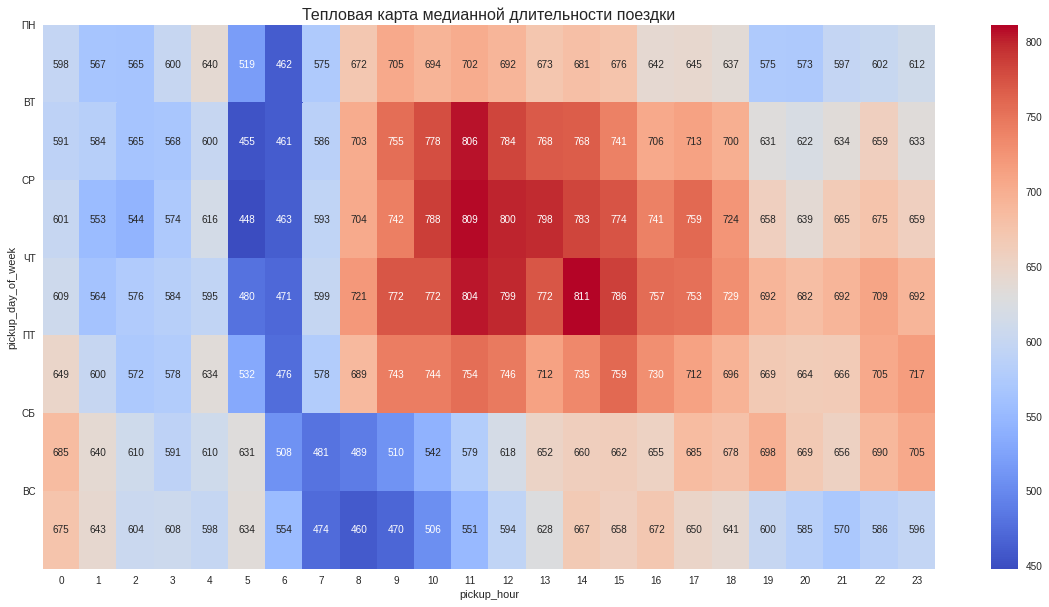

In [ ]:
plt.figure(figsize=(20, 10));
pivot = df_trip.pivot_table(
    values='trip_duration',
    index='pickup_day_of_week',
    columns='pickup_hour',
    aggfunc = 'median',
)
#pivot.columns = pivot.columns.astype('string')
#display(pivot)

heatmap = sns.heatmap(data=pivot, cmap='coolwarm',annot = True, fmt='0.0f');
heatmap.set_title('Тепловая карта медианной длительности поездки', fontsize=16);
order_dow = ['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']
plt.yticks(range(0,7), order_dow, rotation = 'horizontal');

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


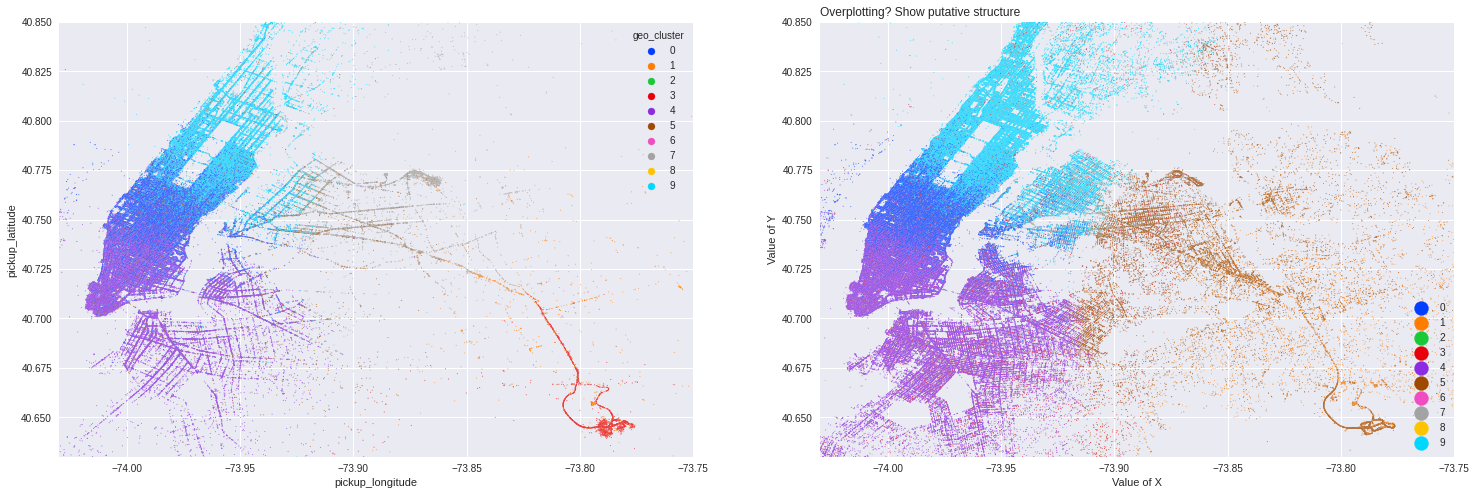

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
# Dataset:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

# Plot
a = sns.scatterplot(x='pickup_longitude' , y='pickup_latitude', data=df_trip, hue='geo_cluster', legend=True, palette="bright", s=1, 
    alpha=.8, ax = ax[0])
a.set_xlim(-74.03, -73.75)
a.set_ylim(40.63, 40.85)

b = sns.scatterplot(x='dropoff_longitude' , y='dropoff_latitude', data=df_trip, hue='geo_cluster', legend=True, palette="bright", s=1, 
    alpha=.8,  ax = ax[1])
b.set_xlim(-74.03, -73.75)
b.set_ylim(40.63, 40.85)

 
# Legend
plt.legend(loc='lower right', markerscale=2)
 
# titles
plt.xlabel('Value of X')
plt.ylabel('Value of Y')
plt.title('Overplotting? Show putative structure', loc='left')
plt.show()

In [ ]:
df_trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458233 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458233 non-null  object 
 1   vendor_id           1458233 non-null  int64  
 2   pickup_datetime     1458233 non-null  object 
 3   dropoff_datetime    1458233 non-null  object 
 4   passenger_count     1458233 non-null  int64  
 5   pickup_longitude    1458233 non-null  float64
 6   pickup_latitude     1458233 non-null  float64
 7   dropoff_longitude   1458233 non-null  float64
 8   dropoff_latitude    1458233 non-null  float64
 9   store_and_fwd_flag  1458233 non-null  object 
 10  trip_duration       1458233 non-null  int64  
 11  pickup_date         1458233 non-null  object 
 12  pickup_hour         1458233 non-null  int64  
 13  pickup_day_of_week  1458233 non-null  int64  
 14  pickup_holiday      1458233 non-null  int64  
 15  total_distance 

In [ ]:
df_trip_test = df_trip[['pickup_longitude','pickup_latitude','geo_cluster']]

In [ ]:
mask1 = df_trip_test['pickup_longitude'] >= -74.03
mask2 = df_trip_test['pickup_longitude'] <= -73.75
mask3 = df_trip_test['pickup_latitude'] >= 40.63
mask4 = df_trip_test['pickup_latitude'] <= 40.85

In [ ]:
print(f'Количество кластеров на первом графике : {len(df_trip_test[mask1 & mask2 & mask3 & mask4]["geo_cluster"].unique())}')

Количество кластеров на первом графике : 8


In [ ]:
df_trip_test1 = df_trip[['dropoff_longitude','dropoff_latitude','geo_cluster']]
mask1 = df_trip_test1['dropoff_longitude'] >= -74.03 
mask2 = df_trip_test1['dropoff_longitude'] <= -73.75
mask3 = df_trip_test1['dropoff_latitude'] >= 40.63 
mask4 = df_trip_test1['dropoff_latitude'] <= 40.85
print(f'Количество кластеров на втором графике : {len(df_trip_test1[mask1 & mask2 & mask3 & mask4]["geo_cluster"].unique())}')

Количество кластеров на втором графике : 7


Анализ:  

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(df_trip.shape))
print('Columns: {}'.format(df_trip.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = df_trip.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


## Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.
Для нас это время окончания поездки.

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [ ]:
# ваш код здесь
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [ ]:
# ваш код здесь
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print('Cреднее по закодированному столбцу vendor_id: {:.2f}'.format(train_data['vendor_id'].mean()))
print('Cреднее по закодированному столбцу store_and_fwd_flag: {:.3f}'.format(train_data['store_and_fwd_flag'].mean()))

Cреднее по закодированному столбцу vendor_id: 0.53
Cреднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице train_data с помощью OneHotEndoder() из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [ ]:
columns_to_change = ['pickup_day_of_week','geo_cluster','events']
# Создание датафрейма
data_onehot = train_data[columns_to_change]

# Создание экземпляра класса OneHotEncoder()
one_hot_encoder = OneHotEncoder(drop = 'first')
# Кодирование признака
ohe_res = one_hot_encoder.fit_transform(data_onehot[columns_to_change])

column_names = one_hot_encoder.get_feature_names_out(columns_to_change)

ohe_df = pd.DataFrame(ohe_res.toarray(), columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat([train_data.reset_index(drop=True).drop(columns_to_change, axis=1), ohe_df], axis=1)

print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


## Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

selector.get_feature_names_out()

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [ ]:
X_train.shape

(977016, 36)

In [ ]:
#подготовим список признаков для построения модели логистической регрессии
list_SelectKBest = list(selector.get_feature_names_out())

In [ ]:
X_train_best = X_train[list_SelectKBest]
X_valid_best = X_valid[list_SelectKBest]

In [ ]:
X_train_best.shape

(977016, 25)

In [ ]:
X_valid_best.shape

(481217, 25)

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
# Создание экземпляра класса MinMaxScaler(), диапазон {0,1}
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# Масштабирование признака
X_train_scaled = minmax_scaler.fit_transform(X_train_best)
X_valid_scaled = minmax_scaler.transform(X_valid_best)

In [ ]:
X_valid_scaled.mean().round(2)

0.26

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Что такое среднеквадратическая логарифмическая ошибка?
Среднеквадратическая логарифмическая ошибка (MSLE) может быть интерпретирована как мера отношения между истинными и предсказанными значениями. Среднеквадратическая логарифмическая ошибка, как следует из названия, является разновидностью среднеквадратичной ошибки. MSLE заботит только процентная разница.

### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)
 
y_train_predicted = model.predict(X_train_scaled)
y_valid_predicted = model.predict(X_valid_scaled)

rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_predicted))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_predicted))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.54
RMSLE_valid: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(include_bias=False)
#poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки

X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled) 
#Генерируем полиномиальные признаки для тестовой выборки

#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_valid_poly.shape)
print(type(X_train_poly))
print(type(X_valid_poly))

(977016, 350)
(481217, 350)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
pd.DataFrame(X_train_poly).to_csv('X_train_poly.csv', sep = ',')
pd.DataFrame(X_valid_poly).to_csv('X_valid_poly.csv', sep = ',')
pd.DataFrame(y_train_log).to_csv('y_train_log.csv', sep = ',')
pd.DataFrame(y_valid_log).to_csv('y_valid_log.csv', sep = ',')

In [ ]:
X_train_poly = pd.read_csv('X_train_poly.csv')
X_valid_poly = pd.read_csv('X_valid_poly.csv')
y_train_log = pd.read_csv('y_train_log.csv')
y_valid_log = pd.read_csv('y_valid_log.csv')

In [ ]:
X_train_poly.drop(X_train_poly.columns[[0]], axis = 1, inplace = True)
X_valid_poly.drop(X_valid_poly.columns[[0]], axis = 1, inplace = True)
y_train_log.drop(y_train_log.columns[[0]], axis = 1, inplace = True)
y_valid_log.drop(y_valid_log.columns[[0]], axis = 1, inplace = True)

In [ ]:
#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
 
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_predict_poly))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_predict_poly))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.47
RMSLE_valid: 0.70


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=1)
#Обучаем модель
ridge_lr_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_predict_poly = ridge_lr_poly.predict(X_valid_poly)

rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_predict_poly))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_predict_poly))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.48
RMSLE_valid: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:

regr1 = DecisionTreeRegressor()
regr1.fit(X_train_scaled, y_train_log)
##DecisionTreeRegressor(max_depth=10, random_state=42)

 
y_train_pred = regr1.predict(X_train_scaled)
y_valid_pred = regr1.predict(X_valid_scaled)
  
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)


RMSLE_train: 0.00
RMSLE_valid: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
numbers = np.zeros((13, 3))

header = ['depth_step', 'rmsle_train', 'rmsle_valid']

data_rmsle = pd.DataFrame(data = numbers, columns = header)

row = 0
for depth_step in range(7, 20):
  regr1 = DecisionTreeRegressor(max_depth = depth_step)
  regr1.fit(X_train_scaled, y_train_log)
  
  y_train_pred = regr1.predict(X_train_scaled)
  y_valid_pred = regr1.predict(X_valid_scaled)
    
  rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred))
  rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred))
  data_rmsle.loc[row,'rmsle_train'] = rmsle_train
  data_rmsle.loc[row,'rmsle_valid'] = rmsle_valid
  data_rmsle.loc[row,'depth_step'] = depth_step
  row+=1

data_rmsle.set_index(['depth_step'], inplace=True)

In [ ]:
data_rmsle.round(2)

,rmsle_train,rmsle_valid
depth_step,,
7.0,0.44,0.45
8.0,0.44,0.44
9.0,0.43,0.44
10.0,0.42,0.43
11.0,0.41,0.43
12.0,0.41,0.43
13.0,0.40,0.43
14.0,0.38,0.44
15.0,0.37,0.44


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


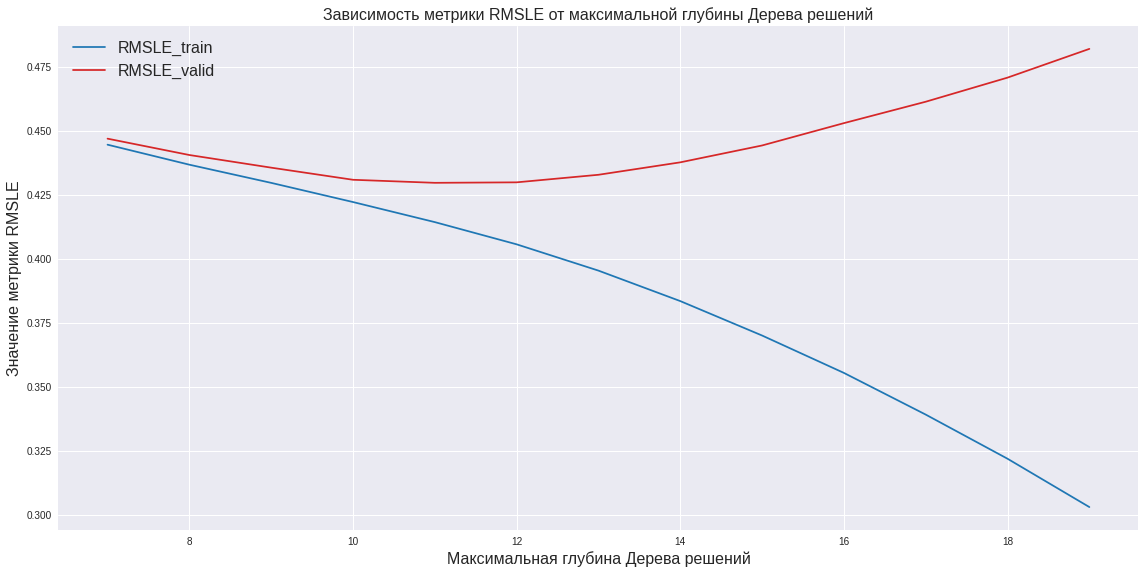

In [ ]:
# Create some mock data
data1 = data_rmsle[['rmsle_train']]
data2 = data_rmsle[['rmsle_valid']]

fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0, 0, 1, 1])

color = 'tab:blue'
axes.plot(data1, color=color)
color = 'tab:red'
axes.plot(data2,color=color)
axes.set_ylabel('Значение метрики RMSLE',fontsize = 16)
axes.set_xlabel('Максимальная глубина Дерева решений',fontsize = 16)
axes.set_title('Зависимость метрики RMSLE от максимальной глубины Дерева решений', fontsize = 16)
axes.legend(['RMSLE_train', 'RMSLE_valid'], fontsize = 16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом ещё не будет наблюдаться переобучение (валидационная кривая ещё не начинает возрастать)

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
regr_rf = RandomForestRegressor(max_depth=12, n_estimators=200, min_samples_split=20, criterion='squared_error', verbose = True, random_state=42)
regr_rf.fit(X_train_scaled, y_train_log)
 
y_train_pred_rf = regr_rf.predict(X_train_scaled)
y_valid_pred_rf = regr_rf.predict(X_valid_scaled)
 
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred_rf))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred_rf))
print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 30.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   19.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE_train: 0.40
RMSLE_valid: 0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.9s finished


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
    learning_rate=0.5,
	  max_depth=6, #максимальная глубина дерева
    n_estimators=100, #количество деревьев
    min_samples_split=30,
    random_state=42 #генератор случайных чисел
  )
gb.fit(X_train_scaled, y_train_log)
 
y_train_pred_gb = gb.predict(X_train_scaled)
y_valid_pred_gb = gb.predict(X_valid_scaled)
 
rmsle_train = sqrt(mean_squared_error(y_train_log, y_train_pred_gb))
rmsle_valid = sqrt(mean_squared_error(y_valid_log, y_valid_pred_gb))

print('RMSLE_train: %.2f' % rmsle_train)
print('RMSLE_valid: %.2f' % rmsle_valid)

RMSLE_train: 0.37
RMSLE_valid: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


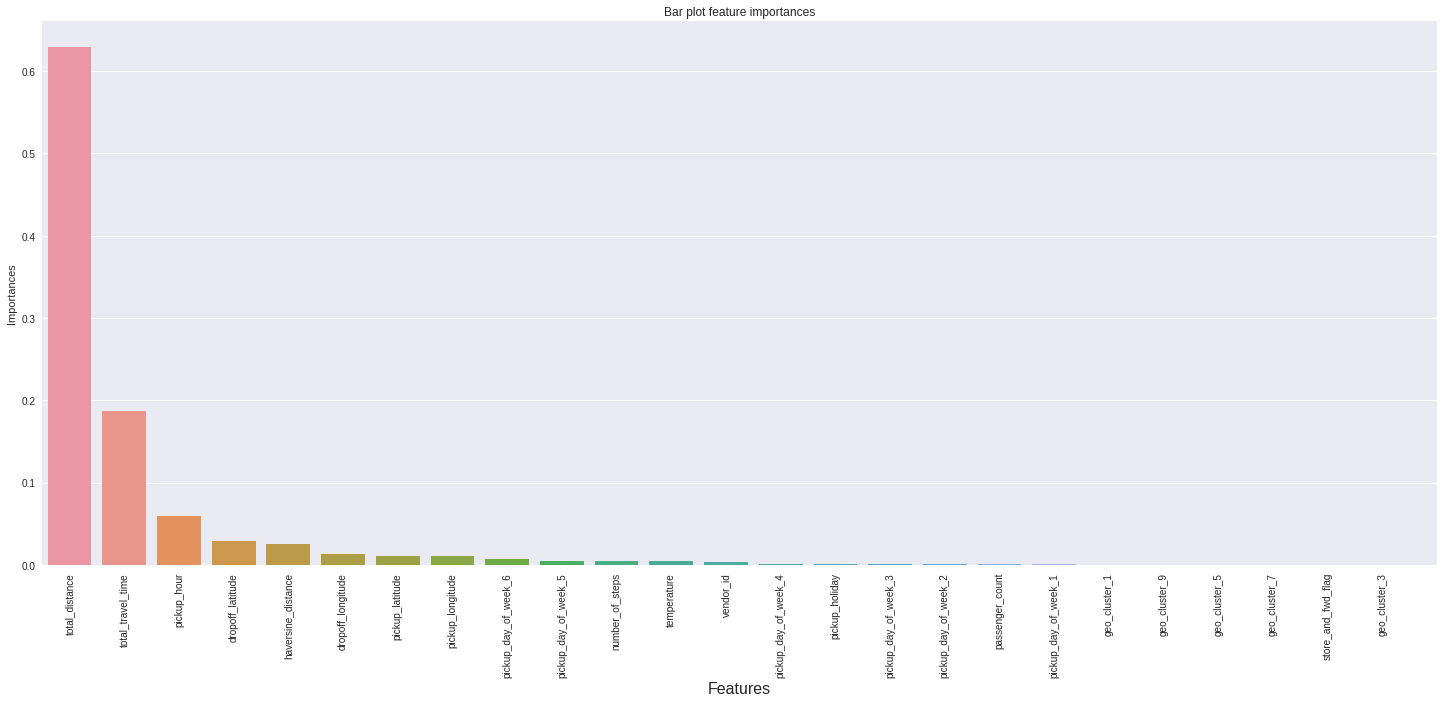

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10)) #фигура + координатная плоскость
feature = X_train_best.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
data_set = pd.DataFrame(data =[feature, feature_importances]).T
data_set.sort_values(by = 1, ascending = False, inplace = True)
#Строим столбчатую диаграмму
sns.barplot(x=data_set[0], y=data_set[1], ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features', fontsize = 16)
plt.xticks(range(0,26), data_set[0], rotation = 'vertical');
ax.set_ylabel('Importances');


### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(y_valid_pred_gb) - 1
meae_valid_min = median_absolute_error(y_valid, y_valid_pred)/60

print('MeAE_valid: {:.1f}'.format(meae_valid_min))

MeAE_valid: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_5/Project5_test_data.zip")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_5/Project5_osrm_data_test.zip")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)

In [ ]:
#test_data = add_geographical_features(test_data)

In [ ]:
#pd.DataFrame(test_data).to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/test_data.csv', sep = ',')

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/test_data.csv')

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           625134 non-null  int64  
 1   id                                   625134 non-null  object 
 2   vendor_id                            625134 non-null  int64  
 3   pickup_datetime                      625134 non-null  object 
 4   passenger_count                      625134 non-null  int64  
 5   pickup_longitude                     625134 non-null  float64
 6   pickup_latitude                      625134 non-null  float64
 7   dropoff_longitude                    625134 non-null  float64
 8   dropoff_latitude                     625134 non-null  float64
 9   store_and_fwd_flag                   625134 non-null  object 
 10  pickup_date                          625134 non-null  object 
 11  pickup_hour  

In [ ]:
test_data.drop(test_data.columns[[0,17]], axis = 1, inplace = True)

In [ ]:
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)

In [ ]:
test_data = fill_null_weather_data(test_data)

In [ ]:
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

In [ ]:
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

Shape of data: (625134, 25)


In [ ]:
# ваш код здесь
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
test_data = test_data.drop(drop_columns, axis=1)

In [ ]:
X_test = test_data[list_SelectKBest]
X_test_scaled = minmax_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [ ]:
y_test_pred_gb = gb.predict(X_test_scaled)

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

In [ ]:
y_test_predict = np.exp(y_test_pred_gb) - 1

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:

In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Project_5/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=list_SelectKBest)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=list_SelectKBest)
dtest = xgb.DMatrix(X_test_scaled, feature_names=list_SelectKBest)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42228	valid-rmse:5.42188
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:1.93568	valid-rmse:1.93565
[20]	train-rmse:0.785057	valid-rmse:0.78601
[30]	train-rmse:0.47891	valid-rmse:0.481079
[40]	train-rmse:0.421415	valid-rmse:0.424272
[50]	train-rmse:0.409768	valid-rmse:0.413082
[60]	train-rmse:0.404627	valid-rmse:0.408336
[70]	train-rmse:0.401096	valid-rmse:0.405208
[80]	train-rmse:0.398925	valid-rmse:0.40334
[90]	train-rmse:0.397165	valid-rmse:0.401898
[100]	train-rmse:0.395485	valid-rmse:0.400554
[110]	train-rmse:0.394275	valid-rmse:0.399562
[120]	train-rmse:0.393263	valid-rmse:0.398871
[130]	train-rmse:0.392228	valid-rmse:0.398092
[140]	train-rmse:0.391054	valid-rmse:0.397375
[150]	train-rmse:0.390064	valid-rmse:0.396831
[160]	train-rmse:0.389417	valid-rmse:0.396358
[170]	train-rmse:0.388484	valid-rmse:0.395757
[180]	train-rmse:0.387527	valid-rmse:0.395144

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39132


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


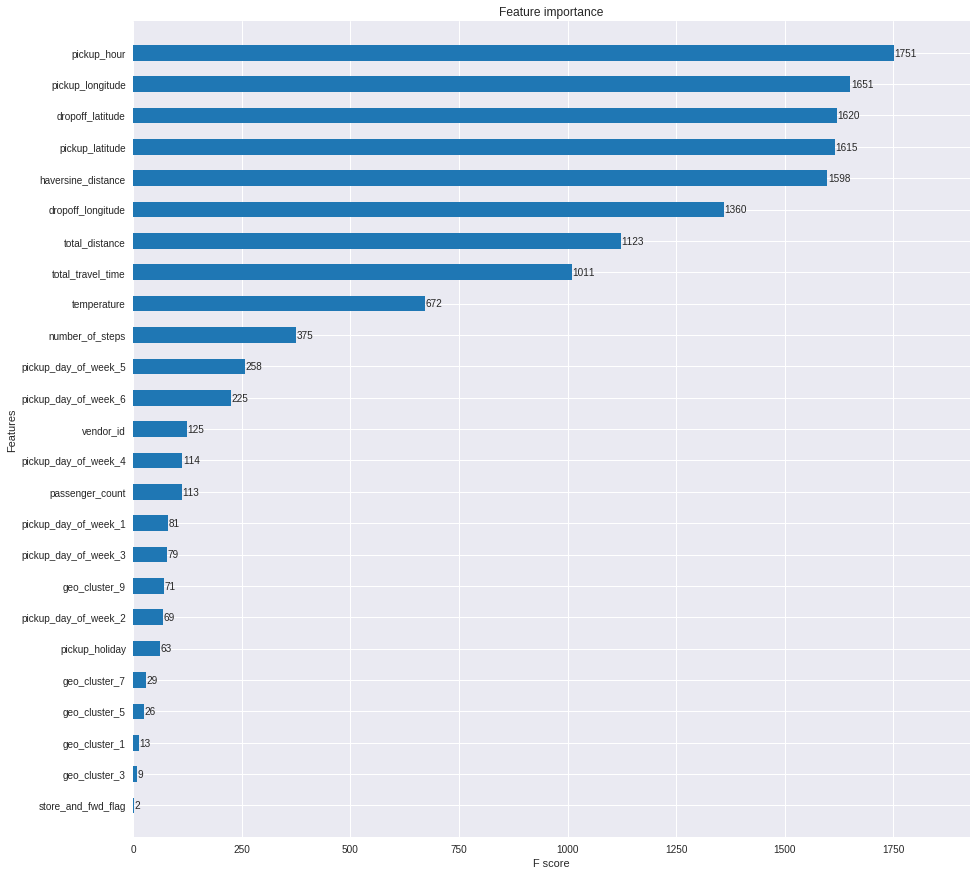

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)